In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import os



## Mean of simulated prices
####  Price = time series of max_test_step lenght in which each value is the mean, for the current step, across all the n_reps repetitions

In [2]:
# Setting the  working directory: close this line when running the code twice or more 
os.chdir("..")

In [3]:
df = np.load("Aggregate test/aggregate_stats_27_4_20.npy", allow_pickle=True)
df = df.item()


mean_price = df["sac_model_1500000_pen1000.0_pen_thresh0.0_rep4.zip"]["price"]["mean"][0] # mean_price is an array of dimension (max_test_step,1) so just focus on 1st term
mean_price=pd.Series(np.log(mean_price)).diff().dropna()
mean_price = mean_price[13:]                                                              # drop 1st year due to instability
price=mean_price

In [4]:
df = np.load("Aggregate test/aggregate_stats_27_4_20.npy", allow_pickle=True)
df = df.item()

##### Store data for mean of simulated prices series

In [5]:

## CREATING A DATABASE WITH A DATE FOR EACH MEASURMENT

date_range = pd.date_range(end="2019-12-31", periods=len(price), freq='ME')
df_price = pd.DataFrame({'price': price, 'date': date_range})

df_price = df_price.rename(columns={'price': 'Value',"date":"Date"})
df_price.set_index('Date', inplace=True)

import statsmodels.api as sm
import matplotlib.pyplot as plt


ts_df = df_price  


#  Create monthly dummies
ts_df['Month'] = ts_df.index.month
dummies = pd.get_dummies(ts_df['Month'], prefix='Month', drop_first=False)
ts_df = pd.concat([ts_df, dummies], axis=1)


#  Run regression
X = ts_df.filter(like='Month_')
y = ts_df['Value']
model = sm.OLS(y, X).fit()

# Plot the monthly profile
monthly_coeffs = model.params.reindex([f'Month_{i}' for i in range(1, 13)])
monthly_coeffs -= np.mean(monthly_coeffs)
std_mean_coeff = np.std(monthly_coeffs)

mean_coeffs1 = monthly_coeffs
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']



## Simulated prices series
####  Sesonality coefficents for each month = mean of the month's coefficients computed for each of the n_reps repetitions


In [6]:
df= np.load("Time series/time_series_stats_27_4_20.npy",allow_pickle=True)
df=df.item()

prices=df["sac_model_1500000_pen1000.0_pen_thresh0.0_rep4.zip"]["price"]

In [7]:
data={}
for k in range(len(prices)):
    data[k]=[]                                  #Initialize an empty list in the `data` dict for key `k` to store results
    price=prices[k]                             #Retrieve the price series corresponding to key `k`
    price=price[13:]                            # Discard the first 13 observations (1st year is unstable)      
    price = np.log(price)                       
    price=pd.Series(prices[k]).diff().dropna()  # Computing 1st difference of the log prices
    date_range = pd.date_range(end="2000-12-31", periods=len(price), freq='ME')
    df_price = pd.DataFrame({'price': price, 'date': date_range})

    df_price = df_price.rename(columns={'price': 'Log_Price',"date":"Date"})
    df_price.set_index('Date', inplace=True)
    ts_df1 = df_price 
    sim_data = df_price


    # Step 2: Create monthly dummies
    ts_df1['Month'] = ts_df1.index.month
    dummies = pd.get_dummies(ts_df1['Month'], prefix='Month', drop_first=False)
    ts_df1 = pd.concat([ts_df1, dummies], axis=1)


    # Step 4: Prepare data and run regression
    X = ts_df1.filter(like='Month_')
    y = ts_df1['Log_Price']
    model = sm.OLS(y, X).fit()
    #print(model.summary())

    # Step 5: Plot the monthly profile
    monthly_coeffs = model.params.reindex([f'Month_{i}' for i in range(1, 13)])
    monthly_coeffs -= np.mean(monthly_coeffs)
    data[k].append(monthly_coeffs)


    # Convert the list of Series in each dict entry to a DataFrame
df_data = pd.DataFrame([v[0].values for v in data.values()], columns=data[0][0].index)
df_data


# Mean for each month  (column)
mean_per_month = df_data.mean(axis=0)
std_per_month = df_data.std(axis=0)


months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']





## Real data series

In [9]:
#  Read metadata (first 6 rows)
metadata_df = pd.read_excel('Plots/ttf_data.xlsx', nrows=6, header=None)
metadata = dict(zip(metadata_df[0], metadata_df[1]))

#  Read time series data (skip first 6 rows)
ts_df = pd.read_excel('Plots/ttf_data.xlsx', skiprows=6, header=None)
ts_df.columns = ['Date', 'Value']  # Rename columns
ts_df['Date'] = pd.to_datetime(ts_df['Date'], format='%m/%d/%Y')  # Convert to datetime
ts_df.set_index('Date', inplace=True)  # Set Date as index



In [10]:
#  Calculate log of prices
ts_df['Log_Price'] = np.log(ts_df['Value'])
real_data = ts_df

#  Create monthly dummies
ts_df['Month'] = ts_df.index.month
dummies = pd.get_dummies(ts_df['Month'], prefix='Month', drop_first=False)
ts_df = pd.concat([ts_df, dummies], axis=1)


#  Prepare data and run regression
X = ts_df.filter(like='Month_')
y = ts_df['Log_Price']
model = sm.OLS(y, X).fit()
#print(model.summary())

#  Plot the monthly profile
monthly_coeffs = model.params.reindex([f'Month_{i}' for i in range(1, 13)])
monthly_coeffs -= np.mean(monthly_coeffs)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']



## Compare the distributions and stagionalities of the three time series

In [11]:
## For simulated data, 1st difference of log price still has to be computed
sim_data = np.log(pd.DataFrame(prices))
sim_data = sim_data.diff(axis=1)
sim_data = np.array(sim_data).flatten()
sim_data = pd.Series(sim_data)

real_data=ts_df["Log_Price"].diff()

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_44438/3049708986.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


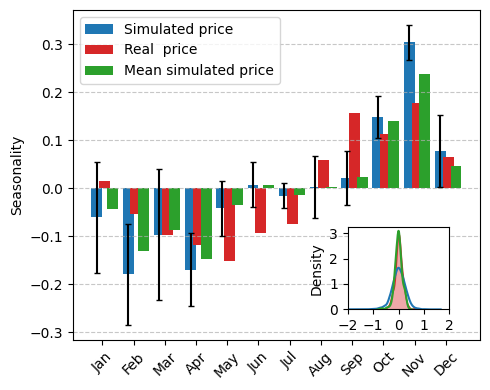

In [12]:

plt.figure(figsize=(5, 4))
ax = plt.gca()

# Bar plot per mean_per_month con barre di errore std
ax.bar(months, mean_per_month, yerr=std_per_month, width=0.35,
       label='Simulated price', color='#1f77b4', capsize=2)
ax.bar([i + 0.25 for i in range(len(months))], monthly_coeffs,
       width=0.35, label='Real  price', color='#d62728')
ax.bar([i + 0.50 for i in range(len(months))], mean_coeffs1,
       width=0.35, label='Mean simulated price', color='#2ca02c', capsize=2)

ax.set_ylabel('Seasonality')
ax.set_xticks([i + 0.175 for i in range(len(months))])
ax.set_xticklabels(months, rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Inset axes 
ax_inset = inset_axes(ax, width="25%", height="25%", loc='lower right', borderpad=2.2)

sns.kdeplot(real_data.dropna(), label='Real', color='#d62728',
            fill=True, alpha=0.4, ax=ax_inset)
sns.kdeplot(sim_data.dropna(), label='Simulated', color='#1f77b4',
            fill=False, alpha=1, ax=ax_inset)
sns.kdeplot(mean_price.dropna(), label="Mean simulated", color="#2ca02c",
            fill=False, alpha=1, ax=ax_inset)

ax_inset.set_ylabel('Density')
ax_inset.set_xlabel(" ")
ax_inset.set_xlim(-2,2)
ax_inset.set_xticks([-2,-1,0,1,2])
ax_inset.set_yticks([0,1,2,3])



plt.tight_layout()
plt.savefig("season_with_inset.png", dpi=500)
plt.show()